In [1]:
from collections import OrderedDict
import numpy as np
import numpy.linalg as nla
from particles.core import SMC
from particles.collectors import Moments

from sdes.sdes import TS_MvOrnsteinUhlenbeck
from sdes.continuous_discrete_ssms import TimeSwitchingGaussianCDSSM
import sdes.feynman_kac as sfk
import particles.state_space_models as ssms

import matplotlib.pyplot as plt
import seaborn as sb
import time

In [2]:
def make_plot(filt_smth_means, filt_smth_stds):
    """
    Plot used in the MV_OU_process_smoothing.ipynb notebook.
    Put here to make the notebook cleaner.
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    for l, title in enumerate(['filtering', 'smoothing']):
        for i in range(dimX):
            axes[l,i].plot(s, x_arr[i], label=f'$X_{i}(s)$ - Time inhomogeneous OU process')
            axes[l,i].plot(ts[1:], et_s[i], 'o', c='#1f77b4', markersize=5., label='$e_t$')
            axes[l,i].plot(ts[1:-2], y_arr[i, :-2], 'x', markersize=10., label='$y_t: \eta=0.4$')
            axes[l,i].plot(ts[-2:], y_arr[i, -2:],'x', markersize=10., c='r', label='$y_t: \eta=0.01$')
            axes[l,i].set_xlabel(r'$t$')
            axes[l,i].set_ylabel(ylabels[i])
            axes[l,i].set_title(f'{title} distribution: $x_{i+1}$')

            for j in range(T+1):
                axes[l,i].axvline(x=j, color='black', linestyle='--', alpha=0.3, linewidth=1)
            axes[l,i].set_xticks([k for k in range(T+1)])

            axes[l,i].plot(ts, filt_smth_means[l][i], c='g', alpha=0.3, label='mean $\mu_t$')
            axes[l,i].plot(ts, filt_smth_means[l][i] + 2*filt_smth_stds[l][i], '--', c='g', alpha=0.3, label='$\mu_t$ +/- 2$\sigma_t$')
            axes[l,i].plot(ts, filt_smth_means[l][i] - 2*filt_smth_stds[l][i], '--', c='g', alpha=0.3)


    fig.suptitle(f'Time-switching MvOU process with switching time at t={t_switch} and t={t_switchY}')
    plt.legend()
    return fig, axes


# Defining a Continuous-Discrete State Space Model

Consider the Ornstein-Uhlenbeck process in general d-dimensions:

$$dX(s) = -\rho X(s) ds + C(s) dB(s) \qquad X(0) = 0. \qquad (1)$$ 

Where, $\rho = (\rho_1, \dots, \rho_d)$ and $C(s): [0, S] \rightarrow \mathbb{R}^{d\times d}$ is a time inhomogeneous, state-independent diffusion coefficient.

This process is observed at $T$ discrete times $0<s_1 < s_2 < \dots < s_T=S$, with noise. So we are working with a continuous time set $\mathcal{S} = [0, S]$ and a discrete one $\mathcal{T} = \{1, \dots T\}$. We set $E_t = X(s_t)$

We assume that observation times are equidistant $s_t - s_{t-1} = \Delta_t = 1$, and we define each observation density $f_t(y_t|e_t)$ to be linear, Gaussian:

$$Y_t |E_t = e_t \sim \mathcal{N}_d(e_t, D(t)) \qquad (2)$$ 

Where $D(t): \mathcal{T} \rightarrow [0, \infty]$ is a map defining the observation noise level at each timestep.

As the OU process above is a linear SDE, it has a tractable transition density $p_t(e_t|e_{t-1})$, given by:

$$E_t|E_{t-1} = e_{t-1} \sim \mathcal{N}_d(\mu(e_{t-1}, \Sigma(e_{t-1})))$$

With $\mu(e_{t-1}) = e^{-\rho \Delta_t} e_{t-1}$, $\Sigma(e_{t-1}) = \int_{s_{t-1}}^{s_t}C^2(u)e^{2\rho u}du$

We now specify the functions $C(t)$ and $D(t)$ in a piecewise fashion, to be:

$$C(s) = \phi_1 \quad s \in [0, s_{t^*}], \quad C(s) = \phi_2 \quad s \in (s_{t^*}, s_T] \qquad (3)$$

$$D(t) = \eta_1 I_{d} \quad t \in \{1, \dots, t^{**}\}, \quad D(t) = \eta_2 I_{d} \quad t \in \{t^{**}+1, \dots, T\} (4)$$

Equation (1)-(4) fully defines a CD-SSM with parameters $\theta = (\rho, \phi_1, \phi_2, \eta_1, \eta_2, t^*, t^{**})$. 

We set $\phi_1 >> \phi_2$, meaning that up to $s_1$ the underlying diffusion is noiser for $s<s_{t^*}$. We set $\eta_1 >> \eta_2$, thus meaning that for the observations $t>{t^{**}}, $y_t$ is highly informative of the location of the latent process.

The random variables $(E_{1:T}, Y_{1:T})$ form a (time-inhomogeneous) linear, Gaussian state space model, and it is possible to derive analytically the filtering and smoothing distributions, through Kalman filtering and smoothing. One can also implement particle filters/smoothers on discrete space, without data augmentation, with the optimal proposal being analytically tractable. Finally, the data augmentation approaches outlined in the contribution can be used. In practice, the particles package does not have an implementation of the Kalman filter/smoother for the 

The `particles.kalman` package cannot implement kalman filtering/smoothing for time inhomogeneous state space models, so we find the benchmark filtering and smoothing distributions by instead using a particle filter with the optimal guided proposal, for a large number of particles.

The toy model above has been constructed so that the future observations are highly informative of the past: so for a reasonable choice of $\theta$ and $T$, we would find that $X_1 | Y_1$ would be a distribution with a higher variance than $X_1 | Y_{1:T}$. It is therefore an appropriate model with which to test smoothing algorithms.

## Define Parameters

In [3]:
# CDSSM parameters
T=10; delta_s = 1.; dimY = 2; eta_sq = 0.4 ** 2
t_switch = 2; t_switchY = 10 # this is t^* and t^** above.

# cdssm_cls = GaussianCDSSM
cdssm_cls = TimeSwitchingGaussianCDSSM

# CDSSM SMC Parameters
cdssm_smc_options = {'N': 10000, 'store_history': True, 'num': 10}

# Benchmark Parameters
benchmark_N = 100000

# --------------------------------------------------------------------------------

# Choose a model SDE:

dimX = dimY # Can change this to whatever we want
sde_cls = TS_MvOrnsteinUhlenbeck
# phi_1 = np.linalg.cholesky(generate_spd_matrix(dimX))
phi_1 = nla.cholesky(np.array([[1., 0.9,], [0.9, 1.]])) # High correlation structure
phi_2 = 0.01 * phi_1 # Same correlation structure, but smaller variance
sde_params = {'dimX': dimX,
              't_switch': t_switch,
            'rho_1': 0.01*np.ones((1, dimX)),
            'mu_1': np.zeros((1, dimX)),
            'phi_1': phi_1,
            'rho_2': 0.01*np.ones((1, dimX)),
            'mu_2': np.zeros((1, dimX)),
            'phi_2': phi_2
                }

In [4]:
# We define the underlying SDE:
sde = sde_cls(**sde_params)

# We can now define a CDSSM: we observe the latent SDE process at discrete points in time with additive noise:
dimX = sde.dimX; s_0=0.; s_T=T*delta_s
x0 = np.array([0.]*dimX).reshape(1, -1) if dimX > 1 else 0.
L = np.eye(dimY) if (dimY > 1 or dimX > 1) else 1. 
CovY = np.eye(dimY)*eta_sq if dimY > 1 else eta_sq

if cdssm_cls == TimeSwitchingGaussianCDSSM:
    obs_params = {'L_1': L, 'covY_1': CovY, 'L_2': L, 'covY_2': 0.001*CovY, 't_switchY': t_switchY, 'x0': x0, 'delta_s': delta_s}
else:
    obs_params = {'L': L, 'covY': CovY, 'x0': x0, 'delta_s': delta_s}

cdssm = cdssm_cls(sde, **obs_params)

# We generate some synthetic data from the process:
np.random.seed(34953)
x, y = cdssm.simulate(T)

idx = x[0].dtype.names[-1]
et_s = np.concatenate([x_path[idx] for x_path in x], axis=0).T # (dimX, T)

## Run the Filtering and the Smoothing on the benchmark SSM, extract the filtering and smoothing moments:

In [5]:
discrete_ssm = cdssm.discrete_ssm()

# Run a benchmark with a very large number of particles to obtain filtering and smoothing distributions:
benchmark_fk = ssms.GuidedPF(ssm=discrete_ssm, data=y)
benchmark_filter = SMC(fk=benchmark_fk, N=benchmark_N, collect=[Moments], store_history=True)
benchmark_filter.run()
backward_samples = benchmark_filter.hist.backward_sampling_mcmc(benchmark_N)

filt_moms = benchmark_filter.summaries.moments

# Could put zeros on the front?
filt_means = np.stack([np.zeros(2)] + [filt_mom['mean'] for filt_mom in filt_moms], axis=1) # (dimX, T)
filt_stds = np.sqrt(np.stack([np.zeros(2)] + [filt_mom['var'] for filt_mom in filt_moms], axis=1))  # (dimX, T)

# Smoothing dists
smth_means = np.stack([np.zeros(2)] + [bw_s.mean(axis=0) for bw_s in backward_samples], axis=1) # (dimX, T)
smth_stds = np.stack([np.zeros(2)] + [bw_s.std(axis=0) for bw_s in backward_samples], axis=1) # (dimX, T)

## Run the Filtering and smoothing using CDSSM SMC, extract the filtering and smoothing moments:

In [10]:
bootstrap_fk = sfk.BootstrapDA(cdssm=cdssm, data=y)
bootstrap_reparameterised_fk = sfk.BootstrapReparameterisedDA(cdssm=cdssm, data=y)
forward_guided_fk = sfk.ForwardGuidedDA(cdssm=cdssm, data=y)
forward_reparameterised_fk = sfk.ForwardReparameterisedDA(cdssm=cdssm, data=y)
backward_guided_fk = sfk.BackwardGuidedDA(cdssm=cdssm, data=y)
backward_reparameterised_fk = sfk.BackwardReparameterisedDA(cdssm=cdssm, data=y)

fks = [bootstrap_fk, bootstrap_reparameterised_fk, forward_guided_fk, forward_reparameterised_fk, backward_guided_fk, backward_reparameterised_fk]
smth_fks = [bootstrap_fk, bootstrap_reparameterised_fk, forward_guided_fk, forward_reparameterised_fk, backward_guided_fk, backward_reparameterised_fk]
# We feed the FK model into a CDSSM SMC object and run the SMC algorithm:
# np.random.seed(2432654)

run_times = 0.
for fk in fks:
    cdssm_smc = sfk.CDSSM_SMC(fk, **cdssm_smc_options)
    print(f'Running CDSSM SMC with {fk.__class__.__name__}')
    cdssm_smc.run()
    print(f'Finished. Run time: {cdssm_smc.cpu_time}')
    run_times += cdssm_smc.cpu_time
print(f'Finished. Total Run time: {run_times}')

Running CDSSM SMC with BootstrapDA
Finished. Run time: 0.8799440409929957
Running CDSSM SMC with BootstrapReparameterisedDA
Finished. Run time: 1.5742639160016552
Running CDSSM SMC with ForwardGuidedDA
Finished. Run time: 12.457103374996223
Running CDSSM SMC with ForwardReparameterisedDA
Finished. Run time: 12.845722416997887
Running CDSSM SMC with BackwardGuidedDA
Finished. Run time: 4.4291899999952875
Running CDSSM SMC with BackwardReparameterisedDA
Finished. Run time: 4.9110041670064675
Finished. Total Run time: 37.097227915990516


In [7]:
# Run a single CDSSM SMC to get the backward samples
import sdes.auxiliary_bridges as axb
cdssm_smc_options = {'N': 10000, 'store_history': True, 'num': 10, 'collect': [Moments]}

fk_cls = sfk.ForwardReparameterisedDA

if fk_cls is sfk.BackwardReparameterisedDA:
    cdssm_fk_options = {'cdssm': cdssm, 'data': y, 'end_pt_proposal_sde_cls': axb.MvOUProposal, 'auxiliary_bridge_cls': axb.MvOUAuxBridge}
if fk_cls is sfk.ForwardReparameterisedDA:
    cdssm_fk_options = {'cdssm': cdssm, 'data': y, 'proposal_sde_cls': axb.MvOUProposal, 'auxiliary_bridge_cls': axb.MvOUAuxBridge}

fk = fk_cls(**cdssm_fk_options)

cdssm_smc = sfk.CDSSM_SMC(fk, **cdssm_smc_options)
cdssm_smc.run()

cd_backward_samples = cdssm_smc.hist.backward_sampling_mcmc(cdssm_smc.N)

/Users/chris_stanton/OneDrive - University College London/PhD/offline-smoothing-for-diffusions/sdes/sdes.py:880: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  rt_cov = self.sigma(t, x)


## Distributions generated from benchmark particle filter:

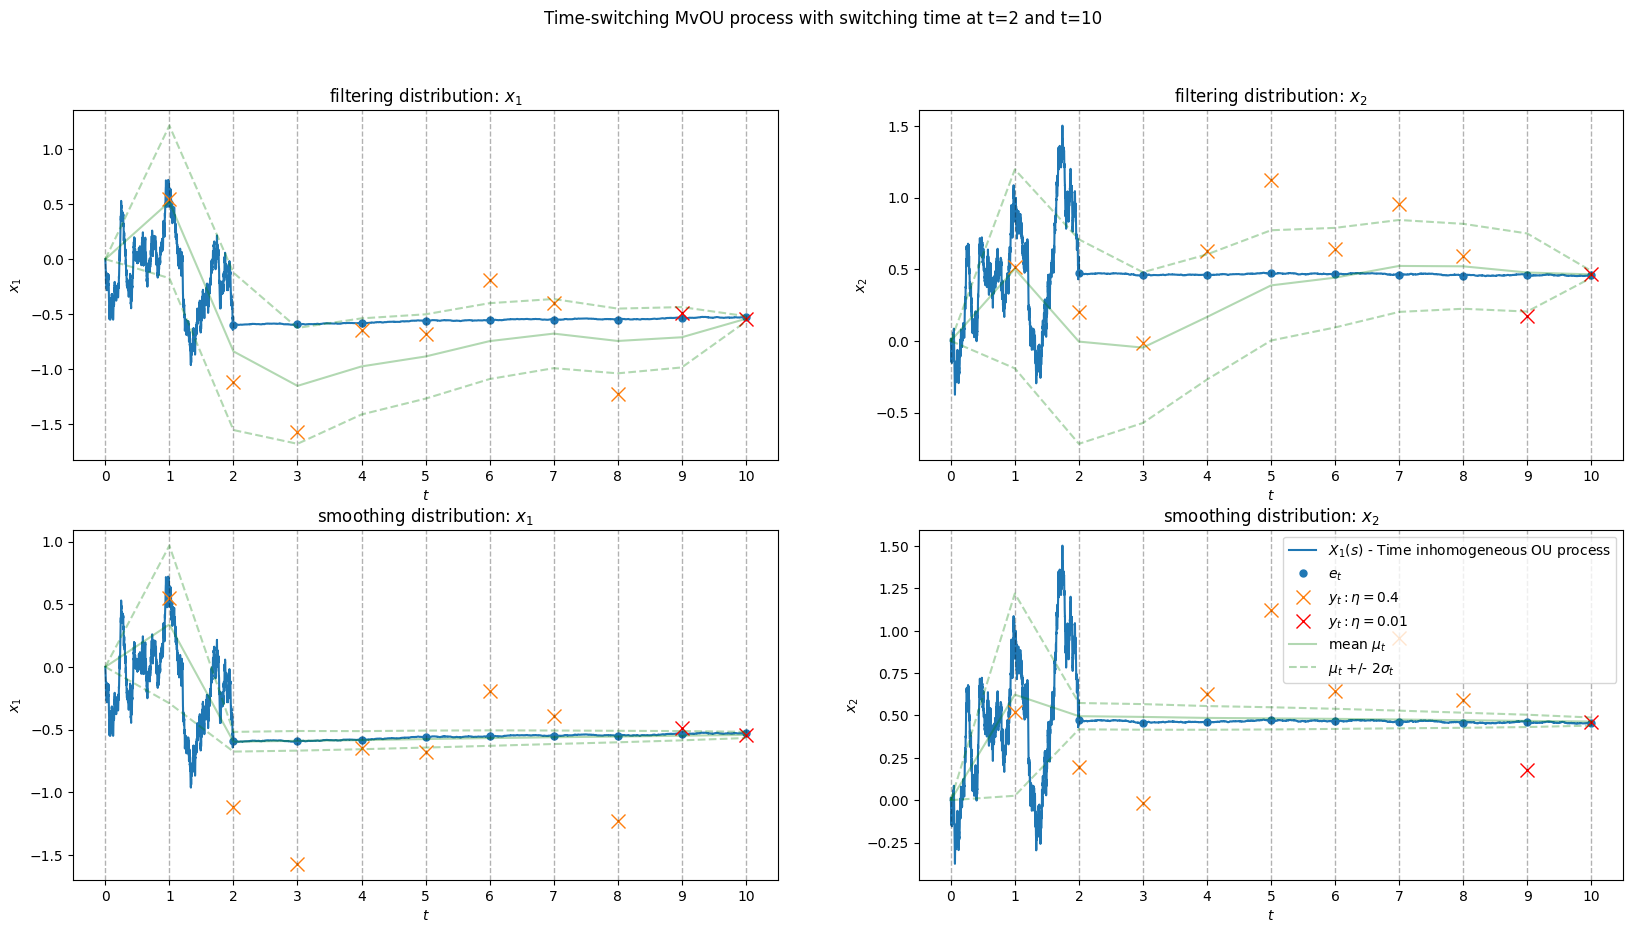

In [8]:

s = np.linspace(0, s_T, num=T*1000+1) # (T*1000+1,)
ts = np.arange(0, T+1, dtype=np.float64)*delta_s # (T+1,)
sa_to_arr = lambda x: np.concatenate([x[name] for name in x.dtype.names], axis=0) # (num, dimX)
x_arr = np.concatenate([x0] + [sa_to_arr(x_t) for x_t in x], axis=0).T # (dimX, 1 + T*num)
y_arr = np.concatenate([y_t for y_t in y]).T # (dimX, T)
ylabels = [r'$x_1$', r'$x_2$']

filt_smth_means = [filt_means, smth_means]; filt_smth_stds = [filt_stds, smth_stds]
make_plot(filt_smth_means, filt_smth_stds)
plt.show()

## Distributions generated from the CDSSM SMC

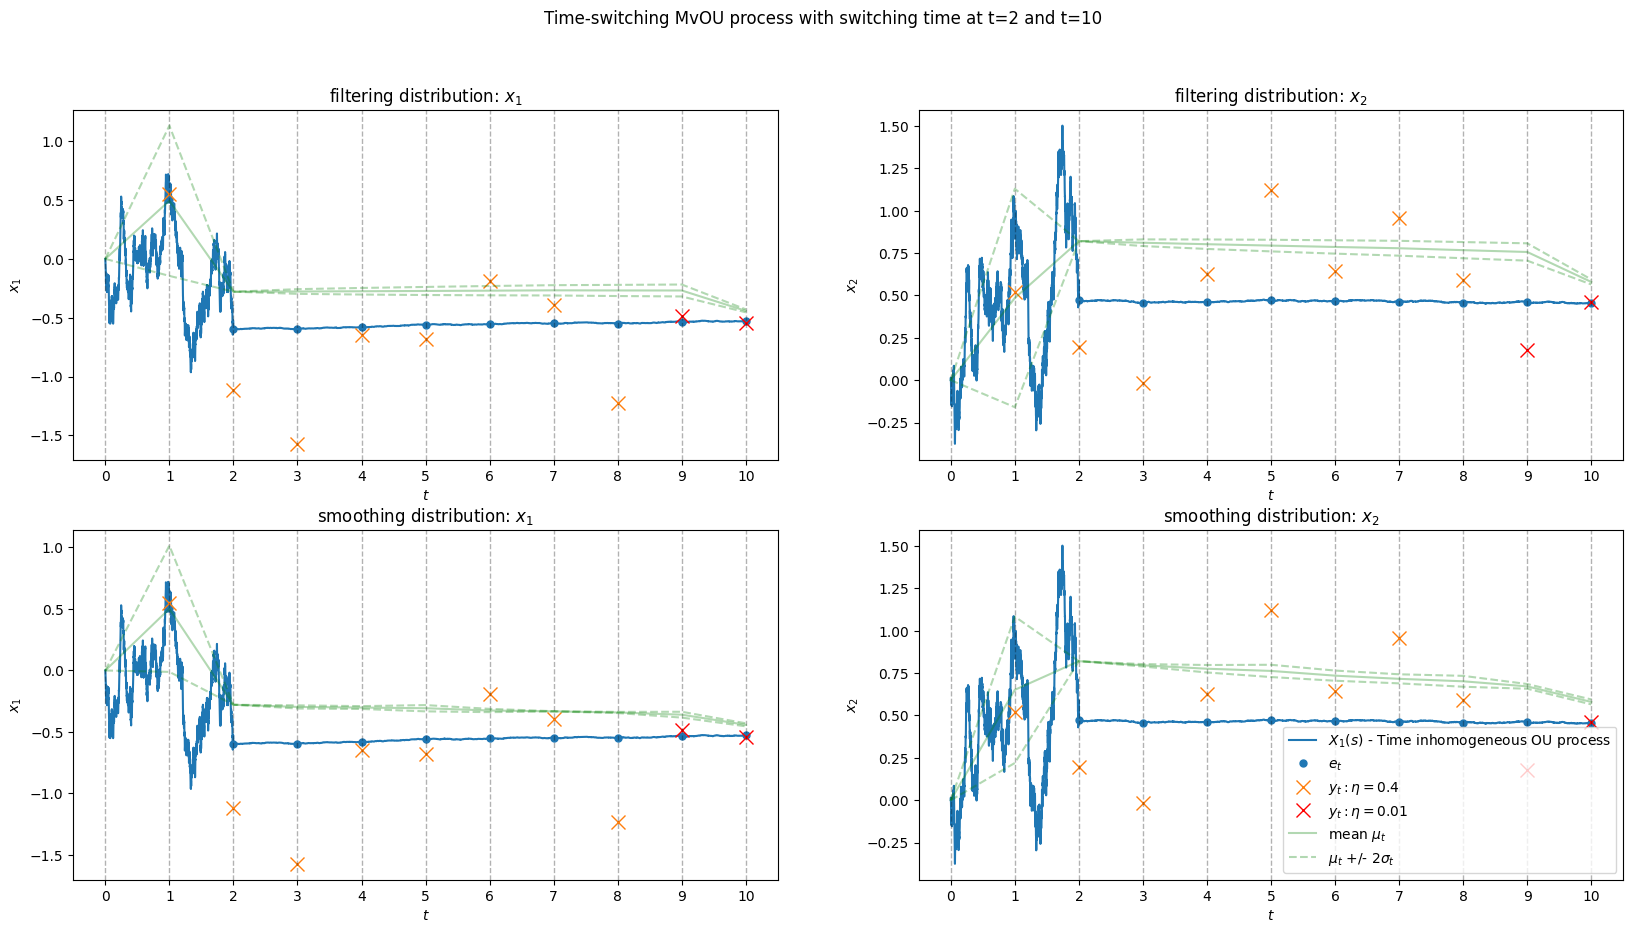

In [9]:

cd_filt_moms = cdssm_smc.summaries.moments

# Could put zeros on the front?
cd_filt_means = np.stack([np.zeros(2)] + [filt_mom['mean'] for filt_mom in cd_filt_moms], axis=1) # (dimX, T)
cd_filt_stds = np.sqrt(np.stack([np.zeros(2)] + [filt_mom['var'] for filt_mom in cd_filt_moms], axis=1))  # (dimX, T)

# Smoothing dists
cd_smth_means = np.stack([np.zeros(2)] + [bw_s[idx].mean(axis=0) for bw_s in cd_backward_samples], axis=1) # (dimX, T)
cd_smth_stds = np.stack([np.zeros(2)] + [bw_s[idx].std(axis=0) for bw_s in cd_backward_samples], axis=1) # (dimX, T)

cd_fs_means = [cd_filt_means, cd_smth_means]; cd_fs_stds = [cd_filt_stds, cd_smth_stds]
fig, ax = make_plot(cd_fs_means, cd_fs_stds)
plt.show()

In [11]:
cdssm_smc.summaries.ESSs

[6111.280301966676,
 1.0,
 9999.998850069738,
 9989.023458980646,
 9982.509743092562,
 9979.872353523288,
 9980.529448157966,
 9697.402459318784,
 9258.931665538357,
 1.6995933830833017]

In [10]:
fk_models = OrderedDict()

# Discrete Time FK
# fk_models['bootstrap'] = TVBootstrap(ssm=TV_LGSSM, data=y)
# fk_models['guided'] = TVGuidedPF(ssm=TV_LGSSM, data=y)

# Continuous Time FK
for fk_model_name, FkModelCls in ALL_SMOOTHING_FK_MODELS.items():
    fk_models[fk_model_name] = FkModelCls(cdssm=tv_ou_cdssm, data=y, num=num)

# Create single SMC objects and run them all:
smc_objects = OrderedDict()

for fk_name, fk_model in fk_models.items():
    smc_objects[fk_name] = SMC(fk=fk_model, N=N, collect=[Moments], store_history=True)

filt_mean = lambda x: x.summaries.moments[0]['mean']
filt_std = lambda x: np.sqrt(x.summaries.moments[0]['var'])

for fk_name, fk_model in fk_models.items():
    print(f'Running filtering for {fk_name}')
    smc = smc_objects[fk_name]
    smc.run()
    print(f"Filtering mean: {filt_mean(smc)}, filtering std: {filt_std(smc)}")

smoothing_samples = OrderedDict()

smth_mean = lambda x: x[0]['1.0'].mean()
smth_std = lambda x: x[0]['1.0'].std()

for fk_name, smc_object in smc_objects.items():
    """
    This is order N^2 smoothing:
    """
    print(f'Running FFBS for {fk_name}')
    t1 = time.perf_counter()
    z = smc_object.hist.backward_sampling_ON2(M)
    smoothing_samples[fk_name] = z
    smoothing_time = time.perf_counter() - t1
    print(f'Smoothing mean: {smth_mean(z)}, smth std: {smth_std(z)}')
    print(f'Smoothing time: {smoothing_time}')
    # z.smoothing_time = smoothing_time


# # Kalman Filter benchmark
# kf = Kalman(ssm=LGSSM, data=y)
# kf.filter()

# # Extract the true p(y_{0:T}) approximated by the filters
# true_py = np.cumsum([a[0][0] for a in kf.logpyt])
# true_pyT = true_py[-1]

NameError: name 'ALL_SMOOTHING_FK_MODELS' is not defined